# 🧠 Construção e Consulta de VectorStores com LangChain, ChromaDB e MistralAI

Bem-vindo! Este notebook demonstra, de forma estruturada, como criar e consultar bancos vetoriais (vectorstores) para diferentes áreas do conhecimento, utilizando PyPDF, LangChain, ChromaDB e embeddings do MistralAI.

A seguir, você verá a definição de uma classe utilitária centralizadora e, depois, como criar gestores (`manager`) para diferentes domínios, como **produtos**, **processos** e **recursos humanos**.


Instalar as dependencias

In [1]:
%pip install langchain langchain_mistralai langchain-groq langchain-community langchain-core langgraph mistralai chromadb ipywidgets pypdf

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Importando as bibliotecas necessárias

In [2]:
import os
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_mistralai import MistralAIEmbeddings
from langchain_groq import ChatGroq
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from typing import TypedDict, List, Dict
from langchain.schema import Document
from langgraph.graph import START, StateGraph, END
from langchain_core.messages import HumanMessage

from dotenv import load_dotenv
load_dotenv()

True

## 1. Classe utilitária `VectorStoreManager`

Esta classe reúne a lógica para:
- Carregar e dividir documentos PDF em chunks,
- Gerar embeddings,
- Persistir bancos vetoriais (vectorstores),
- Criar e retornar retrievers para buscas semânticas.

O objetivo é evitar repetição, organizar e facilitar tanto a manutenção quanto a expansão do projeto.

> **Obs.:** Toda configuração específica (diretório dos dados, onde salvar, nome da coleção) é passada na criação da instância.


In [3]:
class VectorStoreManager:
    def __init__(self, diretorio, persist_directory, collection_name):
        """
        Inicializa o gerenciador de VectorStore.
        
        Args:
            diretorio (str): Caminho para os arquivos PDF.
            persist_directory (str): Caminho para salvar o vectorstore.
            collection_name (str): Nome da coleção no vectorstore.
        """
        self.diretorio = diretorio
        self.persist_directory = persist_directory
        self.collection_name = collection_name

    def load_and_process_documents(self):
        """
        Carrega, divide em chunks e processa os documentos do diretório.
        
        Returns:
            list: Lista de documentos chunkados.
        """
        return RecursiveCharacterTextSplitter(
            chunk_size=1000, chunk_overlap=150
        ).split_documents(PyPDFDirectoryLoader(self.diretorio).load())

    def store_embeddings(self):
        """
        Cria e persiste o vectorstore com os embeddings dos documentos.
        
        Returns:
            Chroma: Instância do vectorstore criado.
        """
        chunks = self.load_and_process_documents()
        embeddings = MistralAIEmbeddings()
        vectordb = Chroma.from_documents(
            chunks,
            embedding=embeddings,
            persist_directory=self.persist_directory,
            collection_name=self.collection_name
        )
        vectordb.persist()
        print(f"Vectorstore criado em {self.persist_directory}")
        return vectordb

    def get_retriever(self, k=3):
        """
        Cria um retriever para consultas semânticas na coleção.
        
        Args:
            k (int): Quantidade de documentos relevantes retornados por busca.
            
        Returns:
            Retriever: Instância configurada para busca semântica.
        """
        embeddings = MistralAIEmbeddings()
        vectordb = Chroma(
            persist_directory=self.persist_directory,
            collection_name=self.collection_name,
            embedding_function=embeddings
        )
        retriever = vectordb.as_retriever(search_kwargs={"k": k})
        return retriever


## 2. Criação dos managers para cada área

Agora, criamos uma instância da classe para cada domínio do seu conhecimento.  
Assim, cada área tem seu próprio pipeline de ingestão e busca, totalmente separado e reaproveitável.

- **produto_manager**: gerencia dados de produtos.
- **processos_manager**: gerencia dados de processos.
- **rh_manager**: gerencia dados de recursos humanos.


#### produto_manager

In [4]:
produto_manager = VectorStoreManager(
    diretorio="data/produtos",
    persist_directory="vectorstores/produtos",
    collection_name="produtos"
)

#### processos_manager

In [5]:
processos_manager = VectorStoreManager(
    diretorio="data/processos",
    persist_directory="vectorstores/processos",
    collection_name="processos"
)

#### rh_manager

In [6]:
rh_manager = VectorStoreManager(
    diretorio="data/recursos_humanos",
    persist_directory="vectorstores/recursos_humanos",
    collection_name="recursos_humanos"
)

## 3. Exemplos de uso dos managers

Com os managers definidos, basta chamar:

- `.store_embeddings()` para criar e persistir o vectorstore (execute uma vez para cada área ao adicionar ou atualizar documentos),
- `.get_retriever()` para obter um retriever pronto para buscas semânticas usando o banco vetorial já criado.

O exemplo abaixo mostra como utilizar ambos métodos para cada área.

---

#### Embeddings

In [7]:
produto_manager.store_embeddings()
processos_manager.store_embeddings()
rh_manager.store_embeddings()

c:\projects\Rag-Multi-Agente-GC\.venv\Lib\site-packages\langchain_mistralai\embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(
C:\Users\mathe\AppData\Local\Temp\ipykernel_14892\2527911323.py:41: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()
Overwriting cache for 0 284


Vectorstore criado em vectorstores/produtos
Vectorstore criado em vectorstores/processos
Vectorstore criado em vectorstores/recursos_humanos


#### Retrievers 

In [8]:
retriever_produto = produto_manager.get_retriever(k=3)
retriever_processos = processos_manager.get_retriever(k=3)
retriever_rh = rh_manager.get_retriever(k=3)

C:\Users\mathe\AppData\Local\Temp\ipykernel_14892\2527911323.py:56: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(


## Definindo a LLM

In [9]:
llm = ChatGroq(model="llama3-70b-8192")  # Ou qualquer outro LLM configurado

Definindo o GraphState

In [10]:
class GraphState(TypedDict):
    question: str
    respostas: List[str]
    answer: str

Criando o agente orquestrador simples

In [12]:
prompt_orquestrador = PromptTemplate(
    input_variables=["question"],
    template="""
Você é um agente que recebe uma pergunta e decide quais dos seguintes domínios ela envolve:

Domínios disponíveis:
- produtos: dúvidas sobre produtos ou serviços, características, preços, disponibilidade, cadastro de produtos, etc.
- processos: dúvidas sobre processos internos, fluxos, processos operacionais, instruções, etc.
- rh: dúvidas sobre folha de pagamento, benefícios, férias, horários, etc.

Dada a pergunta abaixo, retorne uma lista de domínios relevantes no seguinte formato JSON:
{{"dominios": ["produtos", "processos"]}}

Pergunta:
{question}
"""
)

import json

def router(state: GraphState) -> Dict:
    prompt = prompt_orquestrador.format(question=state["question"])
    response = llm.invoke([HumanMessage(content=prompt)])
    try:
        areas = json.loads(response.content)
    except json.JSONDecodeError:
        areas = {"dominios": []}  # fallback
    
    print(areas)
    return {"routes": areas["dominios"]}

Prompts para os agentes especializados

In [13]:
# Prompt Agente de Produtos
prompt_agente_produtos = PromptTemplate(
    input_variables=["question", "context"],
    template="""
Você é um especialista na documentação de produtos da empresa. 
Utilize exclusivamente as informações fornecidas no contexto abaixo para responder à pergunta.

Contexto:
{context}

Pergunta:
{question}

Se a resposta não estiver no contexto, diga "Informação não encontrada no contexto.".
Resposta:
"""
)

# Prompt Agente de Processos
prompt_agente_produtos = PromptTemplate(
    input_variables=["question", "context"],
    template="""
Você é um especialista na documentação de processos da empresa. 
Utilize exclusivamente as informações fornecidas no contexto abaixo para responder à pergunta.

Contexto:
{context}

Pergunta:
{question}

Se a resposta não estiver no contexto, diga "Informação não encontrada no contexto.".
Resposta:
"""
)

# Prompt Agente de RH
prompt_agente_produtos = PromptTemplate(
    input_variables=["question", "context"],
    template="""
Você é um especialista na documentação de Recursos Humanos da empresa. 
Utilize exclusivamente as informações fornecidas no contexto abaixo para responder à pergunta.

Contexto:
{context}

Pergunta:
{question}

Se a resposta não estiver no contexto, diga "Informação não encontrada no contexto.".
Resposta:
"""
)

Criação dos agentes especializados

In [14]:
# Agentes especializados
def agente_processos(state: GraphState):
    docs = retriever_processos.get_relevant_documents(state["question"])
    docs_content = "\n\n".join(doc.page_content for doc in docs)
    prompt_value = prompt_agente_produtos.format(question=state["question"], context=docs_content)
    response = llm.invoke([HumanMessage(content=prompt_value)])
    return {"respostas": state.get("respostas", []) + [response.content]}

def agente_produtos(state: GraphState):
    docs = retriever_produto.get_relevant_documents(state["question"])
    docs_content = "\n\n".join(doc.page_content for doc in docs)
    prompt_value = prompt_agente_produtos.format(question=state["question"], context=docs_content)
    response = llm.invoke([HumanMessage(content=prompt_value)])
    return {"respostas": state.get("respostas", []) + [response.content]}

def agente_rh(state: GraphState):
    docs = retriever_rh.get_relevant_documents(state["question"])
    docs_content = "\n\n".join(doc.page_content for doc in docs)
    prompt_value = prompt_agente_produtos.format(question=state["question"], context=docs_content)
    response = llm.invoke([HumanMessage(content=prompt_value)])
    return {"respostas": state.get("respostas", []) + [response.content]}

Criando o agente combinador

In [15]:
prompt_combina = PromptTemplate(
    input_variables=["question", "respostas"],
    template="""
Você é um agente que combina respostas.

Dada a pergunta e as respostas dos especialistas, gere uma resposta final, clara e sem repetições.

### Pergunta:
{question}

### Respostas dos especialistas:
{respostas}

### Resposta final:
"""
)

def combina(state: GraphState) -> Dict:
    respostas_texto = "\n\n".join(state["respostas"])
    prompt = prompt_combina.format(question=state["question"], respostas=respostas_texto)
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"answer": response.content}

Construção do grafo

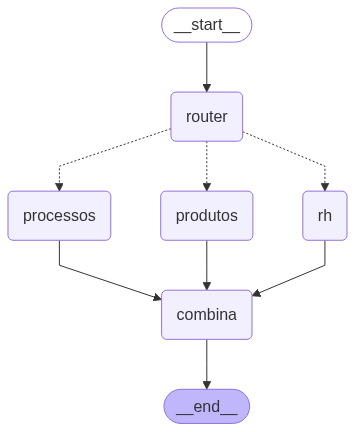

In [16]:
graph = StateGraph(GraphState)

# Adiciona nós
graph.add_node("router", router)
graph.add_node("produtos", agente_produtos)
graph.add_node("processos", agente_processos)
graph.add_node("rh", agente_rh)
graph.add_node("combina", combina)

# Definição das arestas
graph.add_edge(START, "router")

graph.add_conditional_edges("router", lambda x: x["routes"], {
    "produtos": "produtos",
    "processos": "processos",
    "rh": "rh"
})

# Após agentes especializados, vai para combinação
graph.add_edge("produtos", "combina")
graph.add_edge("processos", "combina")
graph.add_edge("rh", "combina")

graph.add_edge("combina", END)

# 🔧 Compilar o grafo
graph_compilado = graph.compile()

from IPython.display import Image, display

display(Image(graph_compilado.get_graph(xray=True).draw_mermaid_png()))

Testando perguntas (1 ou mais dominios)

In [17]:
pergunta = "Qual a metodologia de desenvolvimento usada pela coordenadoria de informatica?"

estado_inicial = {
    "question": pergunta,
    "respostas": [],
    "answer": ""
}

resultado = graph_compilado.invoke(estado_inicial)
print("\nResposta:")
print(resultado["answer"])
print(resultado["respostas"])

{'dominios': ['processos']}


C:\Users\mathe\AppData\Local\Temp\ipykernel_14892\2715679367.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever_processos.get_relevant_documents(state["question"])



Resposta:
Não há informação disponível sobre a metodologia de desenvolvimento usada pela Coordenadoria de Informática.
['Informação não encontrada no contexto.']
